Attempting broader search for control columns...


/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df


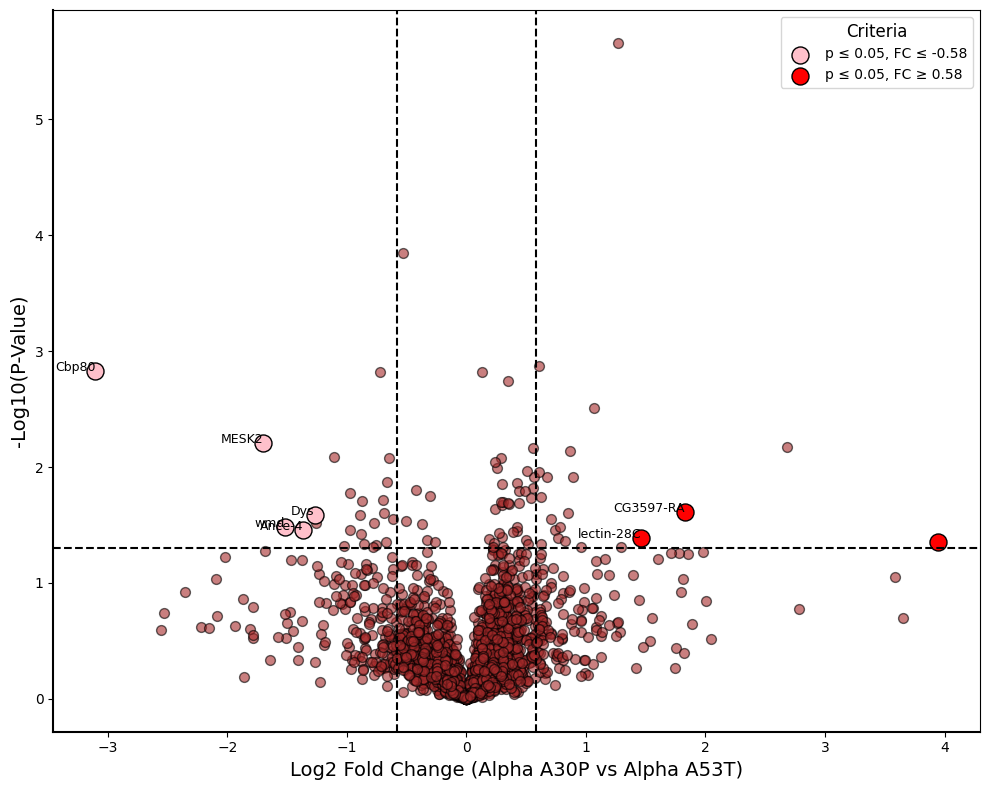

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import re

url = 'https://raw.githubusercontent.com/Olagrace837/Final-Project/refs/heads/main/MUTANT%20CLEANED%20DATA%20%20-%20Copy.csv'
# Assuming the first column contains gene names and should be used as the index
df = pd.read_csv(url, index_col=0)
# Name the index column 'Gene names' and convert it into a regular column
df.index.name = 'Gene names'
df = df.reset_index()

# Clean column names by stripping whitespace
df.columns = df.columns.str.strip()

# Dynamically identify control and KO columns based on common patterns.
# Assuming 'Alpha ' (without 'A30P') columns are controls, and 'Alpha A30P_' columns are knockouts.
# Using regex to capture columns matching the pattern 'Alpha _day_X_Y' or 'Alpha A30P_day_X_Y'
control_cols = sorted([col for col in df.columns if re.match(r'^Alpha _day_\d+_\d+$', col)])
ko_cols = sorted([col for col in df.columns if re.match(r'^Alpha A30P_day_\d+_\d+$', col)])

# If initial regex matching fails, try a more lenient approach, or print df.columns to inspect
if not control_cols:
    print("Attempting broader search for control columns...")
    control_cols = sorted([col for col in df.columns if 'Alpha ' in col and 'A30P' not in col and 'day' in col])
if not ko_cols:
    print("Attempting broader search for KO columns...")
    ko_cols = sorted([col for col in df.columns if 'Alpha A30P_' in col and 'day' in col])


if not control_cols:
    print(f"Error: No control columns found matching expected patterns. Identified columns: {df.columns.tolist()}")
    raise ValueError("Control columns not identified. Please check DataFrame column names and patterns.")
if not ko_cols:
    print(f"Error: No KO columns found matching expected patterns. Identified columns: {df.columns.tolist()}")
    raise ValueError("KO columns not identified. Please check DataFrame column names and patterns.")

numeric_cols = control_cols + ko_cols

for col in numeric_cols:
    # Replace '#VALUE!' string with NaN before converting to numeric
    df[col] = df[col].replace('#VALUE!', np.nan)
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.head()

# Calculate mean for WT and DM replicates
df['WT_Mean'] = df[control_cols].mean(axis=1)
df['hnox_Mean'] = df[ko_cols].mean(axis=1)

# Calculate log2 fold-change
#df['Log2_FC'] = np.log2(df['hnox_Mean'] / df['WT_Mean'].replace(0, np.nan)) (the values are already log transformed, so i have not used this)
df['Log2_FC'] = (df['hnox_Mean'] - df['WT_Mean'].replace(0, np.nan))


# Perform t-tests (two-sample assuming equal variance)
# Ensure all values are numeric for t-test
t_stats, p_values = ttest_ind(
    df[control_cols].values,
    df[ko_cols].values,
    axis=1, nan_policy='omit'
)

# Add p-values and -log10(p-values) to the DataFrame
df['P_Value'] = p_values
df['MinusLog10_P'] = -np.log10(df['P_Value'])

# --- MODIFIED: Filter top 5 significant genes from both sides more explicitly ---
# Define significance and fold change thresholds for determining "top" genes
p_value_threshold = 0.05 # For statistical significance
log2_fc_threshold_abs = 0.58 # For biological significance (absolute value)

# Filter for genes that are statistically significant
significant_df = df[df['P_Value'] < p_value_threshold]

# Get the top 5 upregulated genes among significant ones (with positive Log2_FC above threshold)
top_5_up = significant_df[significant_df['Log2_FC'] >= log2_fc_threshold_abs].nlargest(5, 'Log2_FC')

# Get the top 5 downregulated genes among significant ones (with negative Log2_FC below threshold)
top_5_down = significant_df[significant_df['Log2_FC'] <= -log2_fc_threshold_abs].nsmallest(5, 'Log2_FC')

# Combine these to form the top_genes for labeling on the plot
top_genes = pd.concat([top_5_up, top_5_down]).drop_duplicates(subset=['Gene names']) # Corrected to use 'Gene names'
# --- END MODIFIED SECTION ---

# Separate significant genes for coloring (these now filter from the new 'top_genes')
left_candidates = top_genes[top_genes['Log2_FC'] < -0.58]
right_candidates = top_genes[top_genes['Log2_FC'] >= 0.58]


# Create the volcano plot
plt.figure(figsize=(10, 8))
plt.scatter(df['Log2_FC'], df['MinusLog10_P'], alpha=0.6, edgecolor='black', marker='o', s=50, color='brown') # Changed color to brown

# Highlight significant genes
plt.scatter(left_candidates['Log2_FC'], left_candidates['MinusLog10_P'], color='pink', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≤ -0.58') # Changed color to pink
plt.scatter(right_candidates['Log2_FC'], right_candidates['MinusLog10_P'], color='red', s=150, edgecolor='black', marker='o', label='p ≤ 0.05, FC ≥ 0.58') # Changed color to red

# Add gene labels
gene_name_col = 'Gene names'
if gene_name_col not in df.columns:
    print("Warning: 'Gene names' column not found for labeling.")
else:
    # Filter out entries that are not valid gene names (e.g., NaN, '#VALUE!', numeric strings)
    def is_valid_gene_name(name):
        if pd.isna(name): # Check for numpy NaN
            return False
        name_str = str(name).strip()
        if name_str == '' or name_str == '#VALUE!':
            return False
        try:
            float(name_str) # If it can be converted to a float, it's likely not a gene name
            return False
        except ValueError:
            pass
        return True

    top_genes_for_labeling = top_genes[top_genes[gene_name_col].apply(is_valid_gene_name)]

    for _, row in top_genes_for_labeling.iterrows():
        plt.text(row['Log2_FC'], row['MinusLog10_P'], row[gene_name_col], fontsize=9, ha='right')

# Add reference lines
plt.axhline(-np.log10(0.05), color='black', linestyle='--')
plt.axvline(0.58, color='black', linestyle='--')
plt.axvline(-0.58, color='black', linestyle='--')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# Update axis labels and add legend
plt.xlabel('Log2 Fold Change (Alpha A30P vs Alpha A53T)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)
plt.tight_layout()
# Show the plot
plt.show()

In [4]:
display(df.head())

,Gene names,Alpha A30P_day_1_1,Alpha A30P_day_1_2,Alpha A30P_day_10_1,Alpha A30P_day_10_2,Alpha A53T_day_1_1,Alpha A53T_day_1_2,Alpha A53T_day_10_1,Alpha A53T_day_10_2,Alpha A53T_day_30_1,Alpha A53T_day_30_2,WT_Mean,hnox_Mean,Log2_FC,P_Value,MinusLog10_P
0,NaN,-0.630707,-1.048800,-1.363457,-1.449612,-0.991943,NaN,-1.464066,-1.939095,NaN,-2.285038,-1.670036,-1.123144,0.546892,0.156056,0.806719
1,dnc,-1.834030,-2.350706,-1.820311,-2.124629,-1.187871,NaN,-2.388733,-2.078198,NaN,-2.181804,-1.959152,-2.032419,-0.073267,0.811519,0.090701
2,NaN,-1.984845,NaN,-2.193833,-1.280685,-1.456999,NaN,-2.380521,-2.714633,-2.430820,-2.072483,-2.211091,-1.819788,0.391304,0.306009,0.514266
3,Marf,-1.037977,-1.583549,-1.725899,-2.042992,-0.804048,-1.256528,-1.649095,-1.301017,NaN,-1.980796,-1.398297,-1.597604,-0.199307,0.514792,0.288368
4,Rh4,0.648926,-1.958981,-3.534981,0.174406,NaN,NaN,-0.967448,-1.357825,-0.627471,-1.930765,-1.220877,-1.167657,0.053220,0.959735,0.017849


In [12]:
import re
import numpy as np
from scipy.stats import ttest_ind

# 1. Identify the 'Alpha A53T' control columns for Day 10
control_cols_day10 = sorted([col for col in df.columns if re.match(r'^Alpha A53T_day_10_\d+$', col)])

# 2. Identify the 'Alpha A30P' knockout columns for Day 10
ko_cols_day10 = sorted([col for col in df.columns if re.match(r'^Alpha A30P_day_10_\d+$', col)])

# Ensure columns are found, if not, try a broader search as in the initial script
if not control_cols_day10:
    print("Attempting broader search for control columns for Day 10...")
    control_cols_day10 = sorted([col for col in df.columns if 'Alpha A53T' in col and 'day_10' in col])
if not ko_cols_day10:
    print("Attempting broader search for KO columns for Day 10...")
    ko_cols_day10 = sorted([col for col in df.columns if 'Alpha A30P' in col and 'day_10' in col])

if not control_cols_day10:
    raise ValueError("Control Day 10 columns not identified. Please check DataFrame column names and patterns.")
if not ko_cols_day10:
    raise ValueError("KO Day 10 columns not identified. Please check DataFrame column names and patterns.")

# 3. Create a new DataFrame, df_day10, by copying df
df_day10 = df.copy()

# 4. Calculate the mean expression for the Day 10 control replicates
df_day10['WT_Mean_Day10'] = df_day10[control_cols_day10].mean(axis=1)

# 5. Calculate the mean expression for the Day 10 knockout replicates
df_day10['hnox_Mean_Day10'] = df_day10[ko_cols_day10].mean(axis=1)

# 6. Calculate the Log2 Fold Change for Day 10
df_day10['Log2_FC_Day10'] = df_day10['hnox_Mean_Day10'] - df_day10['WT_Mean_Day10'].replace(0, np.nan)

# 7. Perform an independent t-test for Day 10
t_stats_day10, p_values_day10 = ttest_ind(
    df_day10[control_cols_day10].values,
    df_day10[ko_cols_day10].values,
    axis=1, nan_policy='omit'
)
df_day10['P_Value_Day10'] = p_values_day10

# 8. Calculate the negative base-10 logarithm of the Day 10 p-values
df_day10['MinusLog10_P_Day10'] = -np.log10(df_day10['P_Value_Day10'])

print("Day 10 analysis complete. Displaying head of df_day10:")
# 9. Display the first few rows of the df_day10 DataFrame
display(df_day10.head())

/usr/local/lib/python3.12/dist-packages/scipy/stats/_stats_py.py:6316: RuntimeWarning: invalid value encountered in scalar divide
  svar = ((n1 - 1) * v1 + (n2 - 1) * v2) / df
/usr/local/lib/python3.12/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


Day 10 analysis complete. Displaying head of df_day10:


,Gene names,Alpha A30P_day_1_1,Alpha A30P_day_1_2,Alpha A30P_day_10_1,Alpha A30P_day_10_2,Alpha A53T_day_1_1,Alpha A53T_day_1_2,Alpha A53T_day_10_1,Alpha A53T_day_10_2,Alpha A53T_day_30_1,...,WT_Mean,hnox_Mean,Log2_FC,P_Value,MinusLog10_P,WT_Mean_Day10,hnox_Mean_Day10,Log2_FC_Day10,P_Value_Day10,MinusLog10_P_Day10
0,NaN,-0.630707,-1.048800,-1.363457,-1.449612,-0.991943,NaN,-1.464066,-1.939095,NaN,...,-1.670036,-1.123144,0.546892,0.156056,0.806719,-1.701581,-1.406534,0.295047,0.346098,0.460801
1,dnc,-1.834030,-2.350706,-1.820311,-2.124629,-1.187871,NaN,-2.388733,-2.078198,NaN,...,-1.959152,-2.032419,-0.073267,0.811519,0.090701,-2.233466,-1.972470,0.260996,0.352827,0.452438
2,NaN,-1.984845,NaN,-2.193833,-1.280685,-1.456999,NaN,-2.380521,-2.714633,-2.430820,...,-2.211091,-1.819788,0.391304,0.306009,0.514266,-2.547577,-1.737259,0.810318,0.237497,0.624341
3,Marf,-1.037977,-1.583549,-1.725899,-2.042992,-0.804048,-1.256528,-1.649095,-1.301017,NaN,...,-1.398297,-1.597604,-0.199307,0.514792,0.288368,-1.475056,-1.884446,-0.409389,0.224180,0.649403
4,Rh4,0.648926,-1.958981,-3.534981,0.174406,NaN,NaN,-0.967448,-1.357825,-0.627471,...,-1.220877,-1.167657,0.053220,0.959735,0.017849,-1.162636,-1.680287,-0.517651,0.807403,0.092910


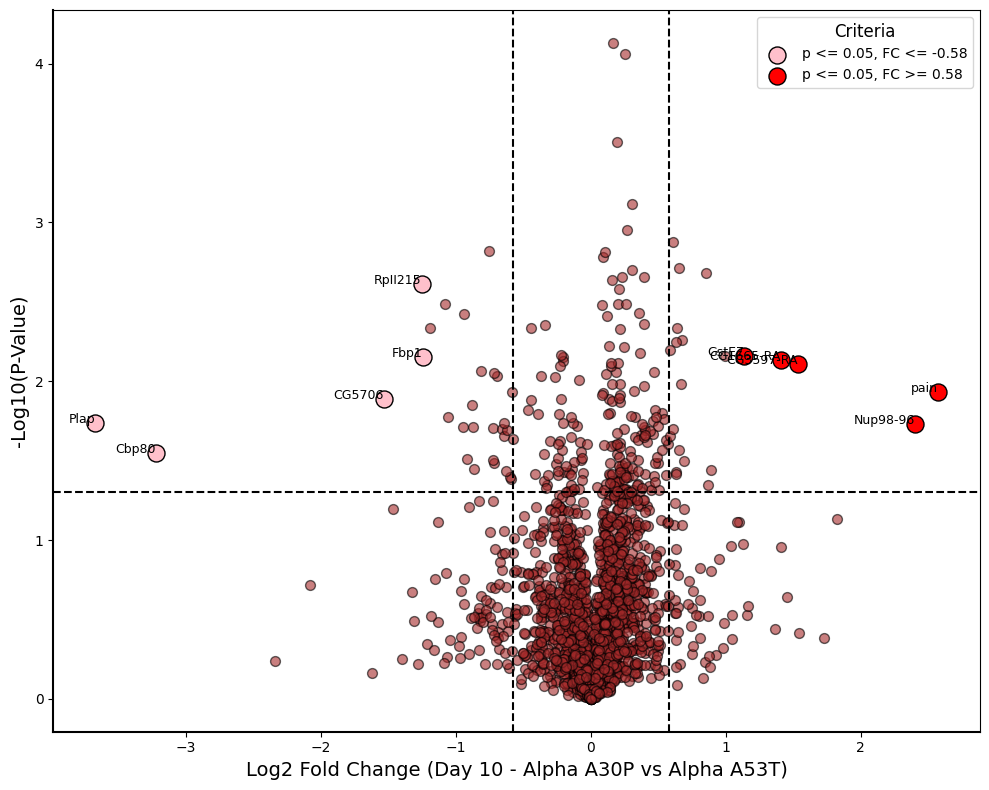

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Define p_value_threshold as 0.05 and log2_fc_threshold_abs as 0.58.
p_value_threshold = 0.05
log2_fc_threshold_abs = 0.58

# 2. Filter the df_day10 DataFrame to create significant_df_day10
significant_df_day10 = df_day10[df_day10['P_Value_Day10'] < p_value_threshold]

# 3. Identify the top 5 up-regulated genes
top_5_up_day10 = significant_df_day10[significant_df_day10['Log2_FC_Day10'] >= log2_fc_threshold_abs].nlargest(5, 'Log2_FC_Day10')

# 4. Identify the top 5 down-regulated genes
top_5_down_day10 = significant_df_day10[significant_df_day10['Log2_FC_Day10'] <= -log2_fc_threshold_abs].nsmallest(5, 'Log2_FC_Day10')

# 5. Concatenate top_5_up_day10 and top_5_down_day10 into top_genes_day10
top_genes_day10 = pd.concat([top_5_up_day10, top_5_down_day10]).drop_duplicates(subset=['Gene names'])

# 6. Create a figure for the volcano plot
plt.figure(figsize=(10, 8))

# 7. Plot all genes from df_day10 as a scatter plot
plt.scatter(df_day10['Log2_FC_Day10'], df_day10['MinusLog10_P_Day10'], alpha=0.6, edgecolor='black', marker='o', s=50, color='brown')

# 8. Highlight the down-regulated genes
left_candidates_day10 = top_genes_day10[top_genes_day10['Log2_FC_Day10'] <= -log2_fc_threshold_abs]
plt.scatter(left_candidates_day10['Log2_FC_Day10'], left_candidates_day10['MinusLog10_P_Day10'], color='pink', s=150, edgecolor='black', marker='o', label='p <= 0.05, FC <= -0.58')

# 9. Highlight the up-regulated genes
right_candidates_day10 = top_genes_day10[top_genes_day10['Log2_FC_Day10'] >= log2_fc_threshold_abs]
plt.scatter(right_candidates_day10['Log2_FC_Day10'], right_candidates_day10['MinusLog10_P_Day10'], color='red', s=150, edgecolor='black', marker='o', label='p <= 0.05, FC >= 0.58')

# 10. Label each gene's name on the plot
gene_name_col = 'Gene names'
if gene_name_col not in df_day10.columns:
    print(f"Warning: '{gene_name_col}' column not found for labeling.")
else:
    def is_valid_gene_name(name):
        if pd.isna(name): # Check for numpy NaN
            return False
        name_str = str(name).strip()
        if name_str == '' or name_str == '#VALUE!':
            return False
        try:
            float(name_str) # If it can be converted to a float, it's likely not a gene name
            return False
        except ValueError:
            pass
        return True

    top_genes_for_labeling_day10 = top_genes_day10[top_genes_day10[gene_name_col].apply(is_valid_gene_name)]

    for _, row in top_genes_for_labeling_day10.iterrows():
        plt.text(row['Log2_FC_Day10'], row['MinusLog10_P_Day10'], row[gene_name_col], fontsize=9, ha='right')

# 11. Add a horizontal dashed line for P-value significance threshold
plt.axhline(-np.log10(p_value_threshold), color='black', linestyle='--')

# 12. Add two vertical dashed lines for Log2 Fold Change thresholds
plt.axvline(log2_fc_threshold_abs, color='black', linestyle='--')
plt.axvline(-log2_fc_threshold_abs, color='black', linestyle='--')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# 13. Set axis labels
plt.xlabel('Log2 Fold Change (Day 10 - Alpha A30P vs Alpha A53T)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)

# 14. Add a legend
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)

# 15. Ensure tight layout
plt.tight_layout()

# 16. Display the plot
plt.show()


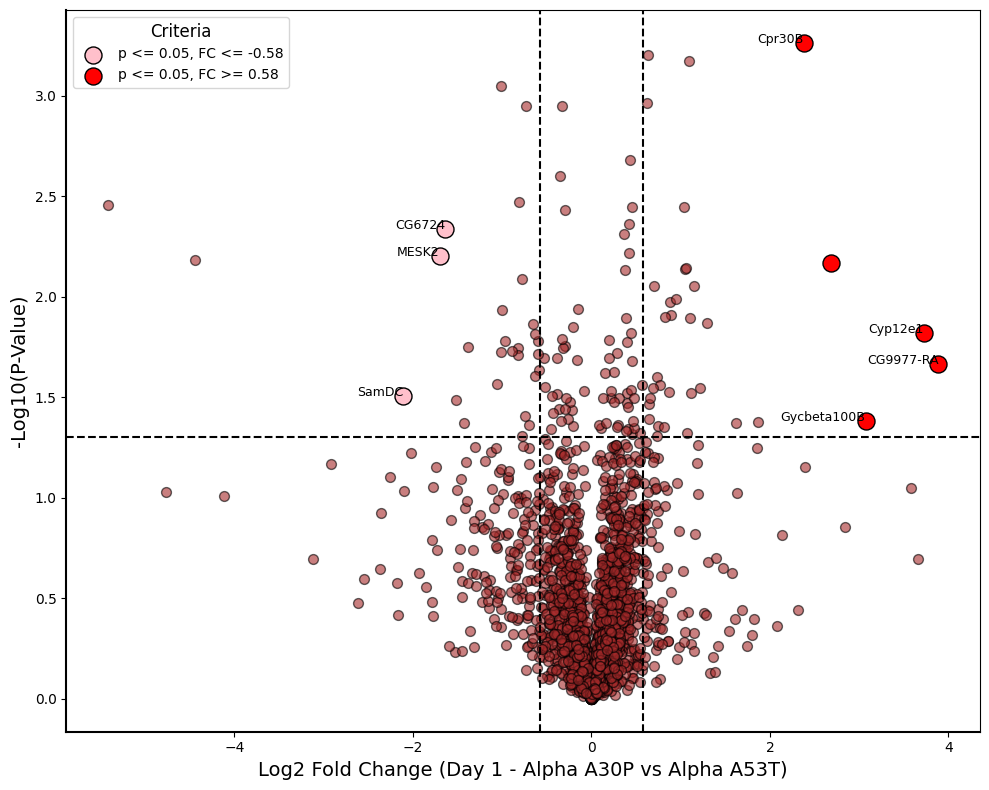

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Define p_value_threshold as 0.05 and log2_fc_threshold_abs as 0.58.
p_value_threshold = 0.05
log2_fc_threshold_abs = 0.58

# Ensure df_day1 exists (it was created in a previous step, but adding a check for robustness)
if 'df_day1' not in locals():
    # Re-create df_day1 if it doesn't exist (this part assumes df and other required vars are available)
    print("df_day1 not found, attempting to reconstruct for plotting.")
    control_cols_day1 = sorted([col for col in df.columns if re.match(r'^Alpha A53T_day_1_\d+$', col)])
    ko_cols_day1 = sorted([col for col in df.columns if re.match(r'^Alpha A30P_day_1_\d+$', col)])

    if not control_cols_day1:
        control_cols_day1 = sorted([col for col in df.columns if 'Alpha A53T' in col and 'day_1' in col])
    if not ko_cols_day1:
        ko_cols_day1 = sorted([col for col in df.columns if 'Alpha A30P' in col and 'day_1' in col])

    if not control_cols_day1 or not ko_cols_day1:
        raise ValueError("Could not identify control or KO columns for Day 1 to reconstruct df_day1.")

    df_day1 = df.copy()
    df_day1['WT_Mean_Day1'] = df_day1[control_cols_day1].mean(axis=1)
    df_day1['hnox_Mean_Day1'] = df_day1[ko_cols_day1].mean(axis=1)
    df_day1['Log2_FC_Day1'] = df_day1['hnox_Mean_Day1'] - df_day1['WT_Mean_Day1'].replace(0, np.nan)

    t_stats_day1, p_values_day1 = ttest_ind(
        df_day1[control_cols_day1].values,
        df_day1[ko_cols_day1].values,
        axis=1, nan_policy='omit'
    )
    df_day1['P_Value_Day1'] = p_values_day1
    df_day1['MinusLog10_P_Day1'] = -np.log10(df_day1['P_Value_Day1'])

# 2. Filter the df_day1 DataFrame to create significant_df_day1
significant_df_day1 = df_day1[df_day1['P_Value_Day1'] < p_value_threshold]

# 3. Identify the top 5 up-regulated genes
top_5_up_day1 = significant_df_day1[significant_df_day1['Log2_FC_Day1'] >= log2_fc_threshold_abs].nlargest(5, 'Log2_FC_Day1')

# 4. Identify the top 5 down-regulated genes
top_5_down_day1 = significant_df_day1[significant_df_day1['Log2_FC_Day1'] <= -log2_fc_threshold_abs].nsmallest(5, 'Log2_FC_Day1')

# 5. Concatenate top_5_up_day1 and top_5_down_day1 into top_genes_day1
top_genes_day1 = pd.concat([top_5_up_day1, top_5_down_day1]).drop_duplicates(subset=['Gene names'])

# 6. Create a figure for the volcano plot
plt.figure(figsize=(10, 8))

# 7. Plot all genes from df_day1 as a scatter plot
plt.scatter(df_day1['Log2_FC_Day1'], df_day1['MinusLog10_P_Day1'], alpha=0.6, edgecolor='black', marker='o', s=50, color='brown')

# 8. Highlight the down-regulated genes
left_candidates_day1 = top_genes_day1[top_genes_day1['Log2_FC_Day1'] <= -log2_fc_threshold_abs]
plt.scatter(left_candidates_day1['Log2_FC_Day1'], left_candidates_day1['MinusLog10_P_Day1'], color='pink', s=150, edgecolor='black', marker='o', label='p <= 0.05, FC <= -0.58')

# 9. Highlight the up-regulated genes
right_candidates_day1 = top_genes_day1[top_genes_day1['Log2_FC_Day1'] >= log2_fc_threshold_abs]
plt.scatter(right_candidates_day1['Log2_FC_Day1'], right_candidates_day1['MinusLog10_P_Day1'], color='red', s=150, edgecolor='black', marker='o', label='p <= 0.05, FC >= 0.58')

# 10. Label each gene's name on the plot
gene_name_col = 'Gene names'
if gene_name_col not in df_day1.columns:
    print(f"Warning: '{gene_name_col}' column not found for labeling.")
else:
    def is_valid_gene_name(name):
        if pd.isna(name):
            return False
        name_str = str(name).strip()
        if name_str == '' or name_str == '#VALUE!':
            return False
        try:
            float(name_str)
            return False
        except ValueError:
            pass
        return True

    top_genes_for_labeling_day1 = top_genes_day1[top_genes_day1[gene_name_col].apply(is_valid_gene_name)]

    for _, row in top_genes_for_labeling_day1.iterrows():
        plt.text(row['Log2_FC_Day1'], row['MinusLog10_P_Day1'], row[gene_name_col], fontsize=9, ha='right')

# 11. Add a horizontal dashed line for P-value significance threshold
plt.axhline(-np.log10(p_value_threshold), color='black', linestyle='--')

# 12. Add two vertical dashed lines for Log2 Fold Change thresholds
plt.axvline(log2_fc_threshold_abs, color='black', linestyle='--')
plt.axvline(-log2_fc_threshold_abs, color='black', linestyle='--')

# Add a border
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)

# 13. Set axis labels
plt.xlabel('Log2 Fold Change (Day 1 - Alpha A30P vs Alpha A53T)', fontsize=14)
plt.ylabel('-Log10(P-Value)', fontsize=14)

# 14. Add a legend
plt.legend(loc='best', fontsize=10, title='Criteria', title_fontsize=12)

# 15. Ensure tight layout
plt.tight_layout()

# 16. Display the plot
plt.show()